<a href="https://colab.research.google.com/github/patriciamedyna/Classifier_page/blob/main/ULMFiT_notfirstpage_victor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
! [ -e /content ] && pip install -Uqq fastai

In [111]:
#hide
!pip install -Uqq fastbook
import fastbook

In [112]:
!pip install nbdev

In [4]:
#hide
from fastbook import *
from IPython.display import display,HTML

In [5]:
from fastai.basics import *
from fastai.text.core import *
from fastai.text.data import *
from fastai.text.models.core import *
from fastai.text.models.awdlstm import *
from fastai.callback.rnn import *
from fastai.callback.progress import *
from fastai.vision import *
from fastai.text.all import *
from fastai.text import *
from datetime import datetime

In [6]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

In [7]:
warnings.filterwarnings(action='ignore')

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, hamming_loss, zero_one_loss, accuracy_score
from sklearn.model_selection import train_test_split

In [46]:
from sklearn.metrics import f1_score

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
path = '/content/drive/MyDrive/Colab Notebooks/Datasets/Victor/small_victor/'

In [11]:
df_train = pd.read_csv(path + 'train/df_train_notfirst.csv', delimiter=',',  error_bad_lines=False, index_col=False)
df_train.head(1)

,page,text,label,is_valid
0,2,"; Bueno E MAnDaLITI\n\nSociedade de Advogados\n\nRAZÕES DO RECURSO INOMINADO\n\nRECORRENTE: ATLANTICO - FUNDO DE INVESTIMENTO EM DIREITOS CREDITÓRIOS NÃO\nPADRONIZADOS\nRECORRIDO: NAILTON LANTYER CORDEIRO DE ARAUJO\n\nAutos de processo n.º 032.2010.034.536-5\nOrigem: 1º JEC DA COMARCA DE SALVADOR - BA\n\nColendo Colégio Recursal,\n\nIlustres Julgadores,\n\n1. SÍNTESE DA DEMANDA\n\nA Parte Recorrida intentou a presente demanda alegando, em síntese, que teve seu\nnome indevidamente incluído no cadastro de proteção ao crédito e que ao diligenciar no\nsentido de obter informações acerca da ins...",outros,False


In [12]:
df_train_tags = pd.read_csv(path + 'train/df_train_tags_notfirst.csv', delimiter=',',  error_bad_lines=False, index_col=False)
df_train_tags.head(1)

,page,label,text,is_valid
0,2,outros,"['\nxxP002\nxxQ00_01 xxbob xxbcet ; Bueno E MAnDaLITI xxecet\nxxeob xxQ00_02\n\nxxP002\nxxQ00_01 xxbob xxbcet Sociedade de Advogados xxecet\nxxeob xxQ00_02\n\nxxP002\nxxQ00_01 xxbob xxbcet RAZÕES DO RECURSO INOMINADO xxecet\nxxeob xxQ00_02\n\nxxP002\nxxQ01_00 xxbob RECORRENTE: ATLANTICO - FUNDO DE INVESTIMENTO EM DIREITOS CREDITÓRIOS NÃO\nPADRONIZADOS\nRECORRIDO: NAILTON LANTYER CORDEIRO DE ARAUJO\nxxeob xxQ01_03\n\nxxP002\nxxQ01_00 xxbob Autos de processo n.º 032.2010.034.536-5\nOrigem: 1º JEC DA COMARCA DE SALVADOR - BA\nxxeob xxQ01_02\n\nxxP002\nxxQ02_00 xxbob Colendo Colégio Recursal,\...",False


In [13]:
df_train.label.value_counts(), df_train.shape, df_train_tags.label.value_counts(), df_train_tags.shape


(outros                              103672
 peticao_do_RE                         9731
 agravo_em_recurso_extraordinario      3954
 sentenca                              1757
 acordao_de_2_instancia                 282
 despacho_de_admissibilidade             96
 Name: label, dtype: int64,
 (119492, 4),
 outros                              103672
 peticao_do_RE                         9731
 agravo_em_recurso_extraordinario      3954
 sentenca                              1757
 acordao_de_2_instancia                 282
 despacho_de_admissibilidade             96
 Name: label, dtype: int64,
 (119492, 4))

In [14]:
df_test = pd.read_csv(path + 'test/df_test_notfirst.csv', delimiter=',', error_bad_lines=False, index_col=False)
df_test.head(1)

,file,page,text,label
0,AI_855935_1366318_50_29062013,2,"Advogados do àAgravado: Vitor Rodrigues Moura —\nOAB/MG 112.768 - com escritório à Rua Desembargador Jorge Fontana nº\n428 — sala 410, Bairro Belvedere, Belo Horizonte/MG.\n\nOutrossim, pede a inscrição dos advogados Bernardo\nAnanias Junqueira Ferraz, OAB/MG 87.253 e Marco Paulo Alves de\nAlmeida, OAB/MG 97.463, para efeito de publicação nos Tribunais\nSuperiores.\n\nA seguir, apresenta as respectivas razões recursais. Requer,\nainda, que formado o instrumento e decorrido o prazo para defesa de agravo,\nos autos sejam enviados ao eg. Supremo Tribunal Federal para apreciação\n\ndo agravo, ...",outros


In [15]:
df_test_tags = pd.read_csv(path + 'test/df_test_tags_notfirst.csv', delimiter=',', error_bad_lines=False, index_col=False)
df_test_tags.head(1)

,page,label,text
0,2,outros,"['\nxxP001\nxxQ00_00 xxbob EXCELENTÍSSIMO SENHOR JUIZ PRESIDENTE DA TURMA RECURSAL\nCÍVEL DA COMARCA DE BELO HORIZONTE\n— MINAS GERAIS\nxxeob xxQ01_03\n\nxxP001\nxxQ02_00 xxbob Recurso Extraordinário nº. 9355158.84.2009.813.0024\nxxeob xxQ02_02\n\nxxP001\nxxQ03_00 xxbob BANCO ITAU S/A, já qualificado nos autos epigrafados,\nmovidos por MAURICIO MORAIS TERRA, vem, respeitosamente, por seus\nadvogados in fine assinados, nos moldes dos arts. 544 e ss. do CPC e 253\ndo RISTJ, interpor o presente Agravo de Instrumento face à decisão que\nnegou seguimento ao Recurso Extraordinário mediante os fu..."


In [16]:
df_test = df_test.drop(columns=['file'])
df_test.head(1)

,page,text,label
0,2,"Advogados do àAgravado: Vitor Rodrigues Moura —\nOAB/MG 112.768 - com escritório à Rua Desembargador Jorge Fontana nº\n428 — sala 410, Bairro Belvedere, Belo Horizonte/MG.\n\nOutrossim, pede a inscrição dos advogados Bernardo\nAnanias Junqueira Ferraz, OAB/MG 87.253 e Marco Paulo Alves de\nAlmeida, OAB/MG 97.463, para efeito de publicação nos Tribunais\nSuperiores.\n\nA seguir, apresenta as respectivas razões recursais. Requer,\nainda, que formado o instrumento e decorrido o prazo para defesa de agravo,\nos autos sejam enviados ao eg. Supremo Tribunal Federal para apreciação\n\ndo agravo, ...",outros


In [17]:
#df_test.to_csv(f'{path}test/df_test_first.csv', index=False)

In [18]:
df_test.label.value_counts(), df_test.shape, df_test_tags.label.value_counts(), df_test_tags.shape

(outros                              63709
 peticao_do_RE                        5876
 agravo_em_recurso_extraordinario     2334
 sentenca                             1216
 acordao_de_2_instancia                 88
 despacho_de_admissibilidade            52
 Name: label, dtype: int64,
 (73275, 3),
 outros                              63709
 peticao_do_RE                        5876
 agravo_em_recurso_extraordinario     2334
 sentenca                             1216
 acordao_de_2_instancia                 88
 despacho_de_admissibilidade            52
 Name: label, dtype: int64,
 (73275, 3))

In [19]:
df_val = pd.read_csv(path + 'val/df_val_notfirst.csv', delimiter=',', error_bad_lines=False, index_col=False)
df_val.head(1)

,page,text,label
0,2,"\n\n4 .\n” ” VO Inlerno Na Tvel 1. 2000 QUIETO = 97 007 OT TE Rio Branco\n000 - .\nE ,\n\nmom . 9 mma\n\n \n\n \n\n \n\n \n\nE a NA\n. = Desembargadora\n\n \n\n. RELATÓRIO\nA Desembargadora Miracele de Souza Lopes Borges ( Relatora ):\n\nO BANCO CRUZEIRO DO SUL SIA, inconformado com a Decisão Mo-\nnocrática que deu provimento à Apelação Civel contra ele interposta por ÁLVARO MONTEIRO\nDOS SANTOS, interpõe Agravo Interno, nos termos dos art. 557, 8 1º, do Código de Processo\nCivil.\n\nAlega o BANCO, em resumo, que ar. Sentença não está em confronto\ncom jurisprudência dos Tribunais Super...",outros


In [20]:
df_val['is_valid'] = True
df_val.head(1)

,page,text,label,is_valid
0,2,"\n\n4 .\n” ” VO Inlerno Na Tvel 1. 2000 QUIETO = 97 007 OT TE Rio Branco\n000 - .\nE ,\n\nmom . 9 mma\n\n \n\n \n\n \n\n \n\nE a NA\n. = Desembargadora\n\n \n\n. RELATÓRIO\nA Desembargadora Miracele de Souza Lopes Borges ( Relatora ):\n\nO BANCO CRUZEIRO DO SUL SIA, inconformado com a Decisão Mo-\nnocrática que deu provimento à Apelação Civel contra ele interposta por ÁLVARO MONTEIRO\nDOS SANTOS, interpõe Agravo Interno, nos termos dos art. 557, 8 1º, do Código de Processo\nCivil.\n\nAlega o BANCO, em resumo, que ar. Sentença não está em confronto\ncom jurisprudência dos Tribunais Super...",outros,True


In [21]:
df_val_tags = pd.read_csv(path + 'val/df_val_tags_notfirst.csv', delimiter=',', error_bad_lines=False, index_col=False)
df_val_tags.head(1)

,page,label,text,is_valid
0,2,outros,"['\nxxP001\nxxQ00_03 xxbob E\nxxeob xxQ00_04\n\nxxP001\nxxQ00_03 xxbob 2\nE\nxxeob xxQ00_04\n\nxxP001\nxxQ00_02 xxbob Sera Cj\nIA JUDICIÁRIA FLS. 0166 -\nxxeob xxQ00_03\n\nxxP001\nxxQ00_00 xxbob Pad\nmm o am alo,\n. <\nmm -. ———— mm Secrelafra”\nxxeob xxQ00_04\n\nxxP001\nxxQ00_00 xxbob \n \n \nxxeob xxQ00_04\n\nxxP001\nxxQ00_02 xxbob \nxxeob xxQ00_04\n\nxxP001\nxxQ00_00 xxbob \nxxeob xxQ00_03\n\nxxP001\nxxQ00_03 xxbob do Rã\nxxeob xxQ00_03\n\nxxP001\nxxQ00_00 xxbob \nxxeob xxQ00_01\n\nxxP001\nxxQ00_00 xxbob = AGRAVO INTERNO na APELAÇÃO CÍVEL n. 2009.003876\n— 9 / 0001.00, de RIO BRA...",True


In [22]:
df_val.label.value_counts(), df_val_tags.label.value_counts(), df_val.shape, df_val_tags.shape

(outros                              67110
 peticao_do_RE                        6486
 agravo_em_recurso_extraordinario     2423
 sentenca                             1336
 acordao_de_2_instancia                116
 despacho_de_admissibilidade            40
 Name: label, dtype: int64,
 outros                              67110
 peticao_do_RE                        6486
 agravo_em_recurso_extraordinario     2423
 sentenca                             1336
 acordao_de_2_instancia                116
 despacho_de_admissibilidade            40
 Name: label, dtype: int64,
 (77511, 4),
 (77511, 4))

In [23]:
df = pd.concat([df_train, df_val], ignore_index = True)
df.tail(1)

,page,text,label,is_valid
197002,2,"Brasília, 08 de julho de 2016\n\nCoordenadoria de Processamento Inicial\n(documento eletrônico)\n\nCertidão gerada em 08/07/2016 às 18:12:07.\n\nEsta certidão pode ser validada em https://www.stf jus. br/portal/autenticacao/autenticarDocumento.asp com o seguinte código CEQ42MWXDOW.\n",outros,True


In [24]:
df_tags = pd.concat([df_train_tags, df_val_tags], ignore_index = True)
df_tags.tail(1)

,page,label,text,is_valid
197002,2,outros,['\nxxP001\nxxQ00_01 xxbob Coordenadoria de Processamento Inicial\nxxeob xxQ00_02\n\nxxP001\nxxQ01_01 xxbob Termo de recebimento e autuação\nxxeob xxQ01_02\n\nxxP001\nxxQ01_00 xxbob Estes autos foram recebidos e autuados nas datas e com as observações abaixo:\nRE nº981213\nPROCED.: PARANÁ\nORIGEM: TRIBUNAL REGIONAL FEDERAL DA 4º REGIÃO\nNÚMERO DO PROCESSO None ORIGEM: 50023107120124047000\nRECTE.(S): INSTITUTO NACIONAL DO SEGURO SOCIAL - INSS\nPROC.(A/SJX(ES): PROCURADOR-GERAL FEDERAL\nRECDO.(A/S): DANIEL CIRQUEIRA\nADV.(A/S): DESIREE PASSOS\nxxeob xxQ02_03\n\nxxP001\nxxQ02_00 xxbob QTD.FO...,True


## Create DataLoader

In [25]:
def get_features(r):

  return r['text']

def get_labels(r):

  return r['label']

In [26]:
df.keys(), df_tags.keys()

(Index(['page', 'text', 'label', 'is_valid'], dtype='object'),
 Index(['page', 'label', 'text', 'is_valid'], dtype='object'))

In [27]:
dblock_train = DataBlock(
    blocks=(TextBlock.from_df(text_cols=['text'], seq_len=72), CategoryBlock),
            get_x=get_features,
            get_y=get_labels,
            splitter = ColSplitter(col='is_valid'))

dls = dblock_train.dataloaders(df, bs=128)

In [28]:
dblock_train_tags = DataBlock(
    blocks=(TextBlock.from_df(text_cols=['text'], seq_len=72), CategoryBlock),
            get_x=get_features,
            get_y=get_labels,
            splitter = ColSplitter(col='is_valid'))

dls_tags = dblock_train_tags.dataloaders(df_tags, bs=128)

## Classification Model

In [29]:
# checkpoint
cbs=[SaveModelCallback()]

In [30]:
now = datetime.today().strftime('%Y-%m-%d-%H:%M:%S')

In [31]:
f1 = FBeta(beta=1, average="weighted")

In [32]:
learn = text_classifier_learner(dls,
                                AWD_LSTM,
                                drop_mult=0.2,
                                path='/content/drive/MyDrive/Colab Notebooks/Datasets/Victor/checkpoints',
                                metrics=[error_rate, accuracy, Perplexity(), f1]).to_fp16()

In [99]:
learn_tags = text_classifier_learner(dls_tags,
                                AWD_LSTM,
                                drop_mult=0.2,
                                path='/content/drive/MyDrive/Colab Notebooks/Datasets/Victor/checkpoints',
                                metrics=[error_rate, accuracy, Perplexity(), f1]).to_fp16()

In [34]:
learn.fine_tune(30, 2e-4, cbs=cbs)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,fbeta_score,time
0,1.250636,1.108498,0.207377,0.792623,3.029803,0.813026,01:39


Better model found at epoch 0 with valid_loss value: 1.1084976196289062.


epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,fbeta_score,time
0,0.994352,0.950557,0.158932,0.841068,2.587150,0.845980,02:39
1,0.774304,0.738338,0.122228,0.877772,2.092456,0.870481,02:39
2,0.563611,0.562922,0.104385,0.895615,1.755795,0.882235,02:39
3,0.428664,0.485307,0.100450,0.899550,1.624673,0.885755,02:39
4,0.375759,0.390908,0.092555,0.907445,1.478322,0.892654,02:39
5,0.326575,0.374092,0.089058,0.910942,1.453671,0.899783,02:40
6,0.313022,0.348157,0.084156,0.915844,1.416455,0.905241,02:40
7,0.278885,0.328731,0.084040,0.915960,1.389204,0.905526,02:40
8,0.277058,0.324922,0.081124,0.918876,1.383922,0.911011,02:40
9,0.253365,0.320709,0.081085,0.918915,1.378105,0.912068,02:40


Better model found at epoch 0 with valid_loss value: 0.9505569934844971.
Better model found at epoch 1 with valid_loss value: 0.7383384108543396.
Better model found at epoch 2 with valid_loss value: 0.562921941280365.
Better model found at epoch 3 with valid_loss value: 0.48530682921409607.
Better model found at epoch 4 with valid_loss value: 0.3909079432487488.
Better model found at epoch 5 with valid_loss value: 0.3740922212600708.
Better model found at epoch 6 with valid_loss value: 0.3481574058532715.
Better model found at epoch 7 with valid_loss value: 0.3287310004234314.
Better model found at epoch 8 with valid_loss value: 0.3249216675758362.
Better model found at epoch 9 with valid_loss value: 0.320709228515625.
Better model found at epoch 10 with valid_loss value: 0.3199170231819153.
Better model found at epoch 11 with valid_loss value: 0.3008037805557251.
Better model found at epoch 12 with valid_loss value: 0.2990128993988037.
Better model found at epoch 13 with valid_loss va

In [35]:
learn.save('model_nf_'+ now)

Path('/content/drive/MyDrive/Colab Notebooks/Datasets/Victor/checkpoints/models/model_nf_2023-08-18-10:54:27.pth')

In [36]:
# load model
learn = learn.load('model_nf_'+ now)

In [100]:
learn_tags.fine_tune(30, 2e-4, cbs=cbs)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,fbeta_score,time
0,1.305468,1.415675,0.366761,0.633239,4.119267,0.696396,01:48


Better model found at epoch 0 with valid_loss value: 1.4156752824783325.


epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,fbeta_score,time
0,1.048454,1.226789,0.299983,0.700017,3.410262,0.738085,03:08
1,0.846134,0.909108,0.223878,0.776122,2.482107,0.787147,03:08
2,0.621369,0.706357,0.199649,0.800351,2.026595,0.802619,03:08
3,0.458122,0.472731,0.130252,0.869748,1.604370,0.845712,03:07
4,0.388516,0.463602,0.134200,0.865800,1.589790,0.844199,03:08
5,0.373597,0.433462,0.132962,0.867038,1.542589,0.845576,03:08
6,0.318051,0.410147,0.117093,0.882907,1.507039,0.856684,03:08
7,0.314296,0.424431,0.117274,0.882726,1.528720,0.856769,03:08
8,0.278422,0.413674,0.117674,0.882326,1.512364,0.856276,03:07
9,0.272759,0.424260,0.117880,0.882120,1.528459,0.856023,03:07


Better model found at epoch 0 with valid_loss value: 1.2267892360687256.
Better model found at epoch 1 with valid_loss value: 0.9091076850891113.
Better model found at epoch 2 with valid_loss value: 0.7063571214675903.
Better model found at epoch 3 with valid_loss value: 0.472731351852417.
Better model found at epoch 4 with valid_loss value: 0.4636021852493286.
Better model found at epoch 5 with valid_loss value: 0.43346211314201355.
Better model found at epoch 6 with valid_loss value: 0.4101470708847046.
Better model found at epoch 11 with valid_loss value: 0.3951336741447449.
Better model found at epoch 12 with valid_loss value: 0.39276835322380066.
Better model found at epoch 13 with valid_loss value: 0.3923531770706177.


In [101]:
learn_tags.save('model_tags_nf_'+ now)

Path('/content/drive/MyDrive/Colab Notebooks/Datasets/Victor/checkpoints/models/model_tags_nf_2023-08-18-10:54:27.pth')

In [102]:
learn_tags = learn_tags.load('model_tags_nf_'+ now)

## Validation

In [37]:
target_names=['acordao_de_2_instancia', 'agravo_em_recurso_extraordinario', 'despacho_de_admissibilidade', 'outros', 'peticao_do_RE', 'sentenca']

In [38]:
# create dataloader of test
dblock_test = DataBlock(
    blocks=(TextBlock.from_df('text', seq_len=72), CategoryBlock),
            get_x=get_features,
            get_y=get_labels)

dloader_test = dblock_test.dataloaders(df_test, bs=128)

In [39]:
test_dl = dloader_test.test_dl(df_test['text'])
preds = learn.get_preds(dl=test_dl, with_decoded=True)

In [40]:
preds,y,losses = learn.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

In [41]:
predictions[:15], y[:15], predictions.shape, y.shape

(tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 torch.Size([77511]),
 torch.Size([77511]))

(#5) [0.28512462973594666,0.07369276881217957,0.9263072609901428,1.3299278020858765,0.9217404352527818]

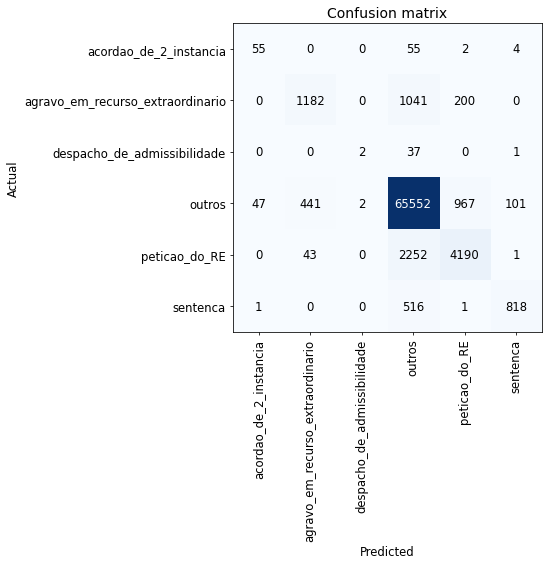

In [42]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=70)
learn.validate()

In [43]:
print(classification_report(y, predictions, target_names=target_names,digits=4))
print(accuracy_score(y, predictions))

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.5340    0.4741    0.5023       116
agravo_em_recurso_extraordinario     0.7095    0.4878    0.5781      2423
     despacho_de_admissibilidade     0.5000    0.0500    0.0909        40
                          outros     0.9438    0.9768    0.9600     67110
                   peticao_do_RE     0.7817    0.6460    0.7074      6486
                        sentenca     0.8843    0.6123    0.7236      1336

                        accuracy                         0.9263     77511
                       macro avg     0.7256    0.5412    0.5937     77511
                    weighted avg     0.9211    0.9263    0.9217     77511

0.9263072338119751


In [47]:
print("F1:", f1_score(y, predictions, average='micro'))
print("Accuracy:", accuracy_score(y, predictions))

F1: 0.9263072338119751
Accuracy: 0.9263072338119751


In [103]:
# create dataloader of test
dblock_test_tags = DataBlock(
    blocks=(TextBlock.from_df('text', seq_len=72), CategoryBlock),
            get_x=get_features,
            get_y=get_labels)

dloader_test_tags = dblock_test_tags.dataloaders(df_test_tags, bs=128)

In [104]:
test_dl = dloader_test_tags.test_dl(df_test_tags['text'])
preds_tags = learn_tags.get_preds(dl=test_dl, with_decoded=True)

In [105]:
preds_tags,y_tags,losses_tags = learn_tags.get_preds(with_loss=True)
predictions_tags = np.argmax(preds_tags, axis = 1)

In [106]:
predictions_tags[:15], y_tags[:15], predictions_tags.shape, y_tags.shape

(tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 torch.Size([77511]),
 torch.Size([77511]))

(#5) [0.3923531770706177,0.105585016310215,0.8944149613380432,1.480460524559021,0.8726296855222587]

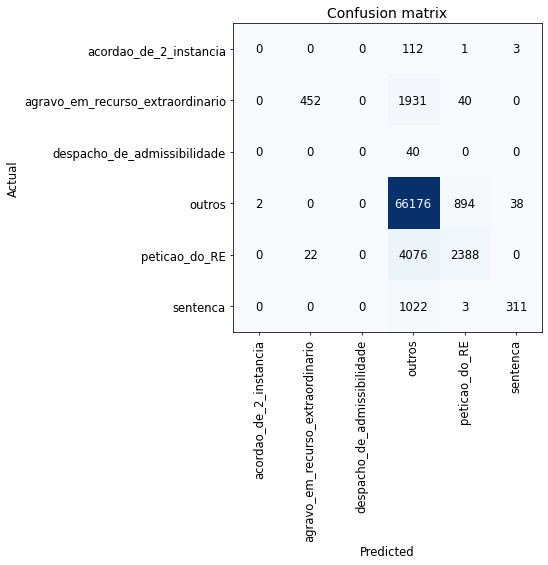

In [107]:
interp_tags = ClassificationInterpretation.from_learner(learn_tags)
interp_tags.plot_confusion_matrix(figsize=(8,8), dpi=70)
learn_tags.validate()

In [108]:
print(classification_report(y_tags, predictions_tags, target_names=target_names, digits=4))
print(accuracy_score(y_tags, predictions_tags))

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.0000    0.0000    0.0000       116
agravo_em_recurso_extraordinario     0.9536    0.1865    0.3120      2423
     despacho_de_admissibilidade     0.0000    0.0000    0.0000        40
                          outros     0.9021    0.9861    0.9422     67110
                   peticao_do_RE     0.7180    0.3682    0.4868      6486
                        sentenca     0.8835    0.2328    0.3685      1336

                        accuracy                         0.8944     77511
                       macro avg     0.5762    0.2956    0.3516     77511
                    weighted avg     0.8862    0.8944    0.8726     77511

0.8944149862600147


In [109]:
print("F1:", f1_score(y_tags, predictions_tags, average='micro'))
print("Accuracy:", accuracy_score(y_tags, predictions_tags))

F1: 0.8944149862600147
Accuracy: 0.8944149862600147


## No Gradual Unfreezing

In [48]:
learn.unfreeze()
learn.fit_one_cycle(5, 2e-2,cbs=cbs)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,fbeta_score,time
0,0.402276,206.836868,0.148224,0.851776,inf,0.796939,02:44
1,0.363531,nan,0.137245,0.862755,nan,0.806633,02:43
2,0.306172,451.074463,0.136329,0.863671,inf,0.802545,02:43
3,0.262736,inf,0.119170,0.880830,inf,0.843332,02:43
4,0.247115,nan,0.082969,0.917031,nan,0.909493,02:43


Better model found at epoch 0 with valid_loss value: 206.8368682861328.


SuggestedLRs(valley=0.009120108559727669)

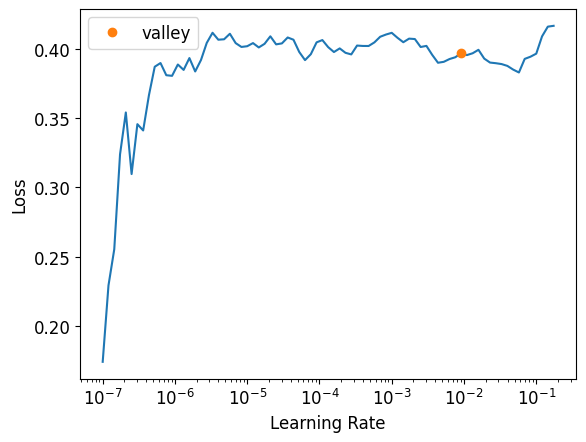

In [49]:
learn.unfreeze()
learn.lr_find()

In [50]:
test_dl = dloader_test.test_dl(df_test['text'])
preds = learn.get_preds(dl=test_dl, with_decoded=True)

In [51]:
preds,y,losses = learn.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

In [52]:
predictions[:15], y[:15], predictions.shape, y.shape

(tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 torch.Size([77511]),
 torch.Size([77511]))

(#5) [206.8368682861328,0.1482241302728653,0.8517758846282959,inf,0.7969385680718899]

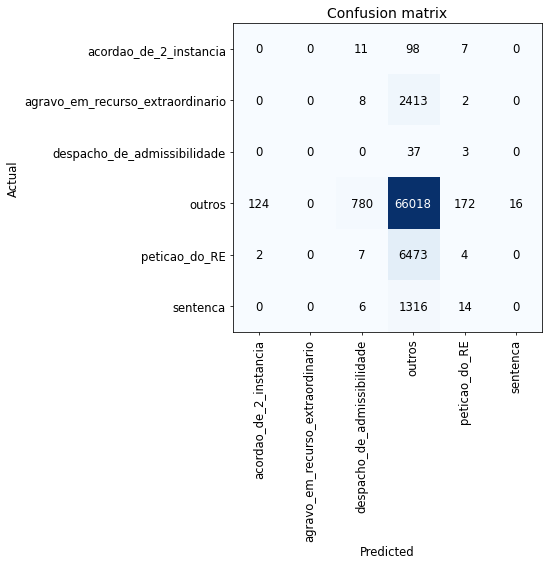

In [53]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=70)
learn.validate()

In [54]:
print(classification_report(y, predictions, target_names=target_names,digits=4))
#print(accuracy_score(y, predictions))

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.0000    0.0000    0.0000       116
agravo_em_recurso_extraordinario     0.0000    0.0000    0.0000      2423
     despacho_de_admissibilidade     0.0000    0.0000    0.0000        40
                          outros     0.8646    0.9837    0.9203     67110
                   peticao_do_RE     0.0198    0.0006    0.0012      6486
                        sentenca     0.0000    0.0000    0.0000      1336

                        accuracy                         0.8518     77511
                       macro avg     0.1474    0.1641    0.1536     77511
                    weighted avg     0.7503    0.8518    0.7969     77511



In [55]:
print("F1:", f1_score(y, predictions, average='micro'))
print("Accuracy:", accuracy_score(y, predictions))

F1: 0.8517758769723007
Accuracy: 0.8517758769723007


In [96]:
learn_tags.unfreeze()
learn_tags.fit_one_cycle(2, 1e-2,cbs=cbs)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,fbeta_score,time
0,0.529267,1.083610,0.134832,0.865167,2.955329,0.803245,03:08
1,0.537931,0.728404,0.142328,0.857672,2.071772,0.799522,03:07


Better model found at epoch 0 with valid_loss value: 1.0836100578308105.
Better model found at epoch 1 with valid_loss value: 0.7284044027328491.


SuggestedLRs(valley=0.0020892962347716093)

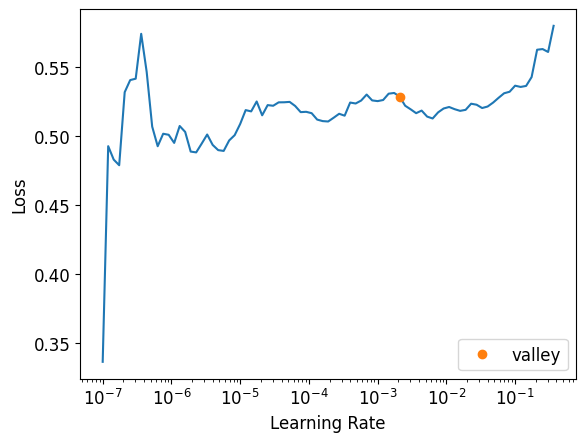

In [97]:
learn_tags.unfreeze()
learn_tags.lr_find()

In [113]:
test_dl = dloader_test_tags.test_dl(df_test_tags['text'])
preds_tags = learn_tags.get_preds(dl=test_dl, with_decoded=True)

In [114]:
preds_tags,y_tags,losses_tags = learn_tags.get_preds(with_loss=True)
predictions_tags = np.argmax(preds_tags, axis = 1)

In [115]:
predictions_tags[:15], y_tags[:15], predictions_tags.shape, y_tags.shape

(tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 torch.Size([77511]),
 torch.Size([77511]))

(#5) [0.3923531770706177,0.105585016310215,0.8944149613380432,1.480460524559021,0.8726296855222587]

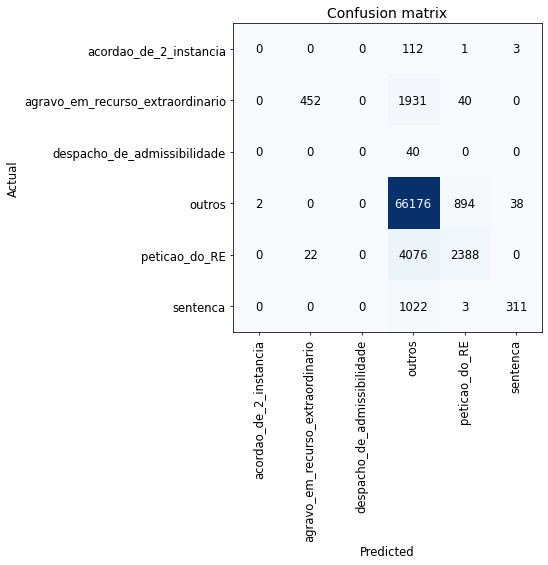

In [116]:
interp_tags = ClassificationInterpretation.from_learner(learn_tags)
interp_tags.plot_confusion_matrix(figsize=(8,8), dpi=70)
learn_tags.validate()

In [117]:
print(classification_report(y_tags, predictions_tags, target_names=target_names, digits=4))
print(accuracy_score(y_tags, predictions_tags))

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.0000    0.0000    0.0000       116
agravo_em_recurso_extraordinario     0.9536    0.1865    0.3120      2423
     despacho_de_admissibilidade     0.0000    0.0000    0.0000        40
                          outros     0.9021    0.9861    0.9422     67110
                   peticao_do_RE     0.7180    0.3682    0.4868      6486
                        sentenca     0.8835    0.2328    0.3685      1336

                        accuracy                         0.8944     77511
                       macro avg     0.5762    0.2956    0.3516     77511
                    weighted avg     0.8862    0.8944    0.8726     77511

0.8944149862600147


In [118]:
print("F1:", f1_score(y_tags, predictions_tags, average='micro'))
print("Accuracy:", accuracy_score(y_tags, predictions_tags))

F1: 0.8944149862600147
Accuracy: 0.8944149862600147


## Others experiments

In [56]:
learn_lm = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.1,metrics=[error_rate, accuracy, Perplexity(), f1]).to_fp16()

In [57]:
learn_lm.fine_tune(30, 2e-2,cbs=cbs)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,fbeta_score,time
0,0.362767,0.360875,0.098012,0.901988,1.434585,0.886299,01:38


Better model found at epoch 0 with valid_loss value: 0.36087530851364136.


epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,fbeta_score,time
0,0.226914,0.300786,0.084943,0.915057,1.350920,0.908366,02:43
1,0.189658,0.288836,0.076570,0.923430,1.334873,0.916326,02:43
2,0.170312,0.277424,0.071822,0.928178,1.319726,0.923462,02:43
3,0.157547,0.319402,0.072699,0.927301,1.376304,0.920469,02:43
4,0.142934,0.323846,0.071035,0.928965,1.382434,0.924640,02:43
5,0.143966,0.302802,0.069474,0.930526,1.353647,0.925584,02:43
6,0.135657,0.334012,0.090490,0.909510,1.396560,0.912931,02:43
7,0.107042,0.308698,0.071074,0.928926,1.361651,0.926728,02:43
8,0.108899,0.405999,0.079137,0.920863,1.500801,0.918661,02:43
9,0.094032,0.514112,0.079434,0.920566,1.672153,0.920157,02:44


Better model found at epoch 0 with valid_loss value: 0.30078551173210144.
Better model found at epoch 1 with valid_loss value: 0.28883618116378784.
Better model found at epoch 2 with valid_loss value: 0.2774237394332886.


In [58]:
test_dl = dloader_test.test_dl(df_test['text'])
preds = learn_lm.get_preds(dl=test_dl, with_decoded=True)

In [59]:
preds,y,losses = learn_lm.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

In [60]:
predictions[:15], y[:15], predictions.shape, y.shape

(tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 torch.Size([77511]),
 torch.Size([77511]))

(#5) [0.2774237394332886,0.07182206213474274,0.9281779527664185,1.319725513458252,0.9234621628066029]

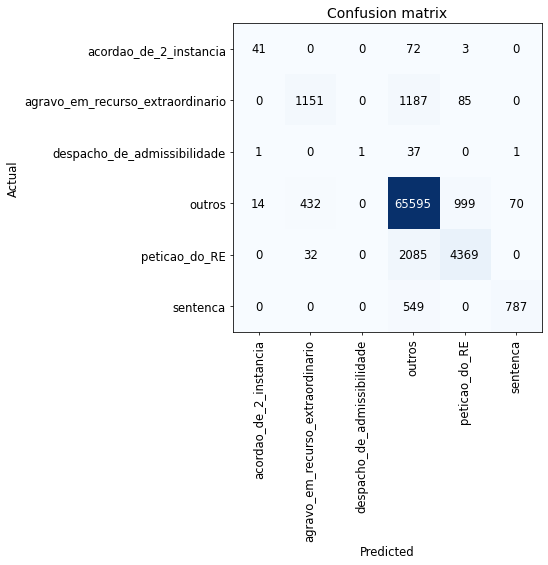

In [61]:
interp = ClassificationInterpretation.from_learner(learn_lm)
interp.plot_confusion_matrix(figsize=(8,8), dpi=70)
learn_lm.validate()

In [62]:
print(classification_report(y, predictions, target_names=target_names,digits=4))
print(accuracy_score(y, predictions))

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.7321    0.3534    0.4767       116
agravo_em_recurso_extraordinario     0.7127    0.4750    0.5701      2423
     despacho_de_admissibilidade     1.0000    0.0250    0.0488        40
                          outros     0.9435    0.9774    0.9601     67110
                   peticao_do_RE     0.8008    0.6736    0.7317      6486
                        sentenca     0.9172    0.5891    0.7174      1336

                        accuracy                         0.9282     77511
                       macro avg     0.8511    0.5156    0.5841     77511
                    weighted avg     0.9236    0.9282    0.9235     77511

0.9281779360348854


In [63]:
print("F1:", f1_score(y, predictions, average='micro'))
print("Accuracy:", accuracy_score(y, predictions))

F1: 0.9281779360348854
Accuracy: 0.9281779360348854


In [119]:
learn_lm_tags = text_classifier_learner(dls_tags, AWD_LSTM, drop_mult=0.1,metrics=[error_rate, accuracy, Perplexity(), f1]).to_fp16()

In [120]:
learn_lm_tags.fine_tune(30, 2e-2,cbs=cbs)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,fbeta_score,time
0,0.391827,0.466137,0.122305,0.877695,1.593825,0.850153,01:50


Better model found at epoch 0 with valid_loss value: 0.4661371111869812.


epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,fbeta_score,time
0,0.227819,0.415228,0.108681,0.891319,1.514716,0.867597,03:09
1,0.179102,0.433845,0.116500,0.883500,1.543180,0.865960,03:09
2,0.166529,0.450770,0.098386,0.901614,1.569520,0.879921,03:10
3,0.154986,0.492056,0.105985,0.894015,1.635676,0.872566,03:10
4,0.142720,0.498040,0.103508,0.896492,1.645493,0.872421,03:10
5,0.148396,0.575178,0.112358,0.887642,1.777446,0.864763,03:10
6,0.126579,0.656655,0.104811,0.895189,1.928331,0.866463,03:10
7,0.120539,0.443723,0.105804,0.894196,1.558499,0.872228,03:10
8,0.100485,0.496221,0.112242,0.887758,1.642502,0.871368,03:11
9,0.091718,0.616381,0.104308,0.895692,1.852213,0.874760,03:11


Better model found at epoch 0 with valid_loss value: 0.4152281880378723.


In [121]:
test_dl = dloader_test_tags.test_dl(df_test_tags['text'])
preds_tags = learn_lm_tags.get_preds(dl=test_dl, with_decoded=True)

In [122]:
preds_tags,y_tags,losses_tags = learn_lm_tags.get_preds(with_loss=True)
predictions_tags = np.argmax(preds_tags, axis = 1)

In [123]:
predictions_tags[:15], y_tags[:15], predictions_tags.shape, y_tags.shape

(tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 torch.Size([77511]),
 torch.Size([77511]))

(#5) [0.4152281880378723,0.10868135094642639,0.891318678855896,1.514716386795044,0.8675973008368923]

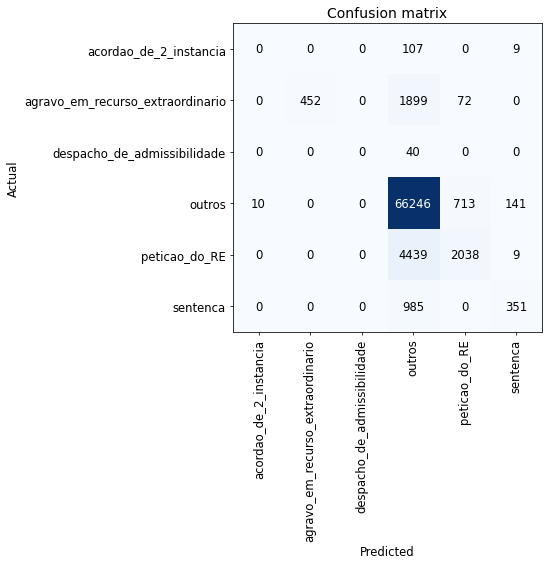

In [124]:
interp_tags = ClassificationInterpretation.from_learner(learn_lm_tags)
interp_tags.plot_confusion_matrix(figsize=(8,8), dpi=70)
learn_lm_tags.validate()

In [125]:
print(classification_report(y_tags, predictions_tags, target_names=target_names, digits=4))
print(accuracy_score(y_tags, predictions_tags))

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.0000    0.0000    0.0000       116
agravo_em_recurso_extraordinario     1.0000    0.1865    0.3144      2423
     despacho_de_admissibilidade     0.0000    0.0000    0.0000        40
                          outros     0.8987    0.9871    0.9408     67110
                   peticao_do_RE     0.7219    0.3142    0.4379      6486
                        sentenca     0.6882    0.2627    0.3803      1336

                        accuracy                         0.8913     77511
                       macro avg     0.5515    0.2918    0.3456     77511
                    weighted avg     0.8816    0.8913    0.8676     77511

0.8913186515462321


In [126]:
print("F1:", f1_score(y_tags, predictions_tags, average='micro'))
print("Accuracy:", accuracy_score(y_tags, predictions_tags))

F1: 0.891318651546232
Accuracy: 0.8913186515462321


## No Gradual Unfreezing

In [64]:
learn_lm.freeze_to(-2)
learn_lm.fit_one_cycle(5, slice(2e-2/(2.6**4),2e-2), cbs=cbs)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,fbeta_score,time
0,0.187555,0.335710,0.076931,0.923069,1.398933,0.914013,01:53
1,0.176892,0.314335,0.078466,0.921534,1.369349,0.916232,01:53
2,0.139942,0.324992,0.073267,0.926733,1.384019,0.922526,01:53
3,0.103360,0.326063,0.068829,0.931171,1.385502,0.928112,01:53
4,0.087043,0.486912,0.077576,0.922424,1.627283,0.921634,01:53


Better model found at epoch 0 with valid_loss value: 0.3357101082801819.
Better model found at epoch 1 with valid_loss value: 0.3143352270126343.


In [65]:
test_dl = dloader_test.test_dl(df_test['text'])
preds = learn_lm.get_preds(dl=test_dl, with_decoded=True)

In [66]:
preds,y,losses = learn_lm.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

In [67]:
predictions[:15], y[:15], predictions.shape, y.shape

(tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 torch.Size([77511]),
 torch.Size([77511]))

(#5) [0.3143352270126343,0.07846628129482269,0.9215337038040161,1.3693486452102661,0.9162322809233839]

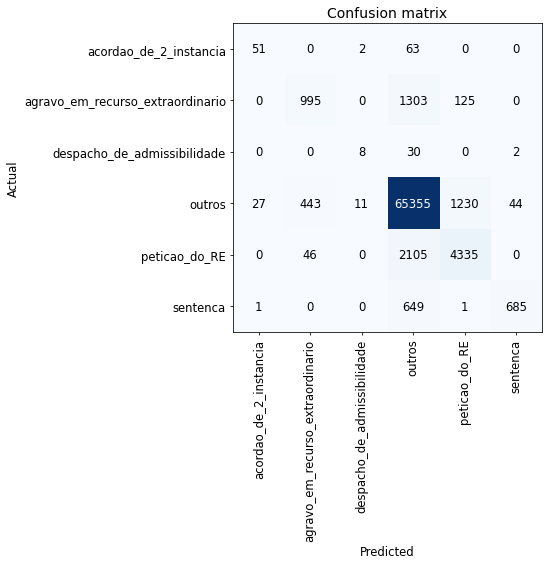

In [68]:
interp = ClassificationInterpretation.from_learner(learn_lm)
interp.plot_confusion_matrix(figsize=(8,8), dpi=70)
learn_lm.validate()

In [69]:
print(classification_report(y, predictions, target_names=target_names,digits=4))
print(accuracy_score(y, predictions))

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.6456    0.4397    0.5231       116
agravo_em_recurso_extraordinario     0.6705    0.4106    0.5093      2423
     despacho_de_admissibilidade     0.3810    0.2000    0.2623        40
                          outros     0.9403    0.9738    0.9568     67110
                   peticao_do_RE     0.7617    0.6684    0.7120      6486
                        sentenca     0.9371    0.5127    0.6628      1336

                        accuracy                         0.9215     77511
                       macro avg     0.7227    0.5342    0.6044     77511
                    weighted avg     0.9161    0.9215    0.9162     77511

0.9215337177948937


In [70]:
print("F1:", f1_score(y, predictions, average='micro'))
print("Accuracy:", accuracy_score(y, predictions))

F1: 0.9215337177948937
Accuracy: 0.9215337177948937


In [127]:
learn_lm_tags.freeze_to(-2)
learn_lm_tags.fit_one_cycle(5, slice(2e-2/(2.6**4),2e-2), cbs=cbs)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,fbeta_score,time
0,0.272347,0.463780,0.176259,0.823741,1.590073,0.821887,02:11
1,0.234840,0.453828,0.110268,0.889732,1.574328,0.865775,02:11
2,0.200248,0.407526,0.103908,0.896092,1.503095,0.871167,02:10
3,0.151688,0.436024,0.101211,0.898789,1.546546,0.875425,02:10
4,0.135892,0.448823,0.103056,0.896944,1.566468,0.875888,02:10


Better model found at epoch 0 with valid_loss value: 0.4637801945209503.
Better model found at epoch 1 with valid_loss value: 0.453828364610672.
Better model found at epoch 2 with valid_loss value: 0.4075261056423187.


In [128]:
test_dl = dloader_test_tags.test_dl(df_test_tags['text'])
preds_tags = learn_lm_tags.get_preds(dl=test_dl, with_decoded=True)

In [129]:
preds_tags,y_tags,losses_tags = learn_lm_tags.get_preds(with_loss=True)
predictions_tags = np.argmax(preds_tags, axis = 1)

In [130]:
predictions_tags[:15], y_tags[:15], predictions_tags.shape, y_tags.shape

(tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 torch.Size([77511]),
 torch.Size([77511]))

(#5) [0.4075261056423187,0.10390783101320267,0.8960921764373779,1.5030946731567383,0.8711669036227725]

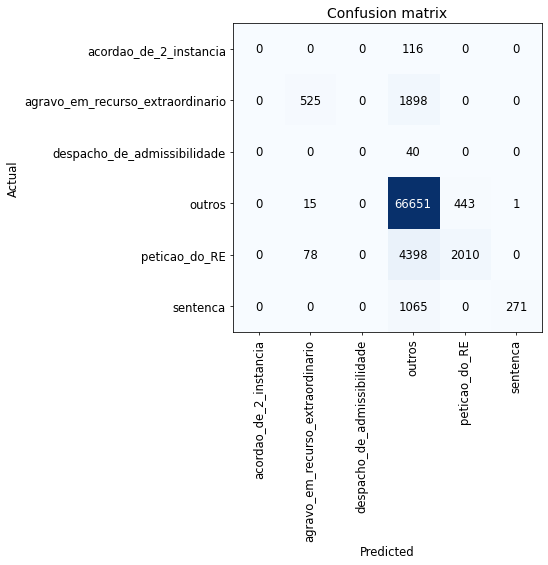

In [131]:
interp_tags = ClassificationInterpretation.from_learner(learn_lm_tags)
interp_tags.plot_confusion_matrix(figsize=(8,8), dpi=70)
learn_lm_tags.validate()

In [132]:
print(classification_report(y_tags, predictions_tags, target_names=target_names, digits=4))
print(accuracy_score(y_tags, predictions_tags))

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.0000    0.0000    0.0000       116
agravo_em_recurso_extraordinario     0.8495    0.2167    0.3453      2423
     despacho_de_admissibilidade     0.0000    0.0000    0.0000        40
                          outros     0.8986    0.9932    0.9435     67110
                   peticao_do_RE     0.8194    0.3099    0.4497      6486
                        sentenca     0.9963    0.2028    0.3371      1336

                        accuracy                         0.8961     77511
                       macro avg     0.5940    0.2871    0.3459     77511
                    weighted avg     0.8904    0.8961    0.8712     77511

0.8960921675633136


In [133]:
print("F1:", f1_score(y_tags, predictions_tags, average='micro'))
print("Accuracy:", accuracy_score(y_tags, predictions_tags))

F1: 0.8960921675633136
Accuracy: 0.8960921675633136


In [71]:
learn_lm.freeze_to(-3)
learn_lm.fit_one_cycle(10, slice(2e-2/2/(2.6**4),2e-2/2), cbs=cbs)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,fbeta_score,time
0,0.127744,0.311354,0.073448,0.926552,1.365273,0.923630,02:17
1,0.162569,0.299806,0.073628,0.926372,1.349597,0.921914,02:17
2,0.144708,0.283493,0.075512,0.924488,1.327759,0.921012,02:17
3,0.130703,0.339688,0.079989,0.920011,1.404509,0.915030,02:17
4,0.121181,0.298081,0.072467,0.927533,1.347271,0.926043,02:17
5,0.095074,0.372887,0.075357,0.924643,1.451920,0.922748,02:18
6,0.070907,0.362101,0.067010,0.932990,1.436345,0.930656,02:18
7,0.048360,0.423768,0.064055,0.935945,1.527707,0.933938,02:18
8,0.045298,0.438220,0.072932,0.927068,1.549945,0.926459,02:17
9,0.032798,0.453787,0.062469,0.937531,1.574263,0.934919,02:17


Better model found at epoch 0 with valid_loss value: 0.3113543391227722.
Better model found at epoch 1 with valid_loss value: 0.2998063266277313.
Better model found at epoch 2 with valid_loss value: 0.2834926247596741.


In [72]:
test_dl = dloader_test.test_dl(df_test['text'])
preds = learn_lm.get_preds(dl=test_dl, with_decoded=True)

In [73]:
preds,y,losses = learn_lm.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

In [74]:
predictions[:15], y[:15], predictions.shape, y.shape

(tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 torch.Size([77511]),
 torch.Size([77511]))

(#5) [0.2834926247596741,0.0755118653178215,0.9244881272315979,1.3277591466903687,0.9210116575410543]

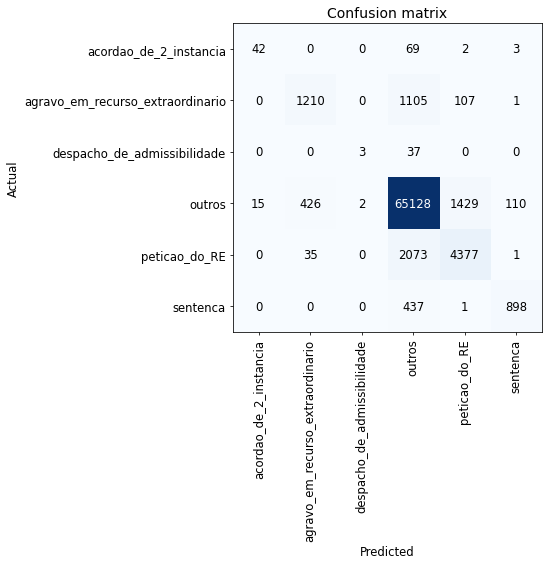

In [75]:
interp = ClassificationInterpretation.from_learner(learn_lm)
interp.plot_confusion_matrix(figsize=(8,8), dpi=70)
learn_lm.validate()

In [76]:
print(classification_report(y, predictions, target_names=target_names,digits=4))
print(accuracy_score(y, predictions))

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.7368    0.3621    0.4855       116
agravo_em_recurso_extraordinario     0.7241    0.4994    0.5911      2423
     despacho_de_admissibilidade     0.6000    0.0750    0.1333        40
                          outros     0.9460    0.9705    0.9581     67110
                   peticao_do_RE     0.7399    0.6748    0.7059      6486
                        sentenca     0.8865    0.6722    0.7646      1336

                        accuracy                         0.9245     77511
                       macro avg     0.7722    0.5423    0.6064     77511
                    weighted avg     0.9203    0.9245    0.9210     77511

0.9244881371676278


In [77]:
print("F1:", f1_score(y, predictions, average='micro'))
print("Accuracy:", accuracy_score(y, predictions))

F1: 0.9244881371676278
Accuracy: 0.9244881371676278


In [134]:
learn_lm_tags.freeze_to(-3)
learn_lm_tags.fit_one_cycle(10, slice(2e-2/2/(2.6**4),2e-2/2), cbs=cbs)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,fbeta_score,time
0,0.171239,0.432569,0.108269,0.891732,1.541211,0.871760,02:39
1,0.189471,0.407419,0.105443,0.894557,1.502933,0.883009,02:39
2,0.197316,0.515101,0.103211,0.896789,1.673808,0.869583,02:39
3,0.160489,0.447754,0.106398,0.893602,1.564793,0.882003,02:40
4,0.148525,0.541801,0.098322,0.901678,1.719100,0.878874,02:40
5,0.123733,0.432216,0.096490,0.903510,1.540668,0.886229,02:41
6,0.099664,0.605972,0.099831,0.900169,1.833032,0.877158,02:51
7,0.070770,0.621382,0.106965,0.893035,1.861498,0.873604,03:13
8,0.058733,0.693567,0.107430,0.892570,2.000840,0.870356,02:58
9,0.047700,0.678145,0.106669,0.893331,1.970220,0.872267,02:40


Better model found at epoch 0 with valid_loss value: 0.43256875872612.
Better model found at epoch 1 with valid_loss value: 0.40741851925849915.


In [135]:
test_dl = dloader_test_tags.test_dl(df_test_tags['text'])
preds_tags = learn_lm_tags.get_preds(dl=test_dl, with_decoded=True)

In [136]:
preds_tags,y_tags,losses_tags = learn_lm_tags.get_preds(with_loss=True)
predictions_tags = np.argmax(preds_tags, axis = 1)

In [137]:
predictions_tags[:15], y_tags[:15], predictions_tags.shape, y_tags.shape

(tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 torch.Size([77511]),
 torch.Size([77511]))

(#5) [0.40741851925849915,0.10544309765100479,0.8945568799972534,1.5029330253601074,0.8830089927907666]

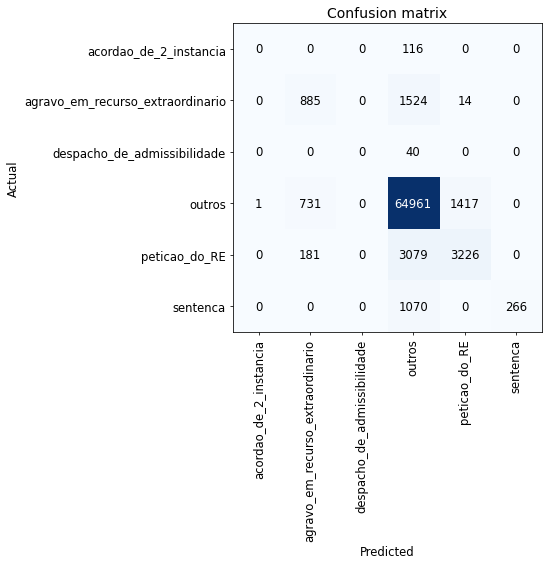

In [138]:
interp_tags = ClassificationInterpretation.from_learner(learn_lm_tags)
interp_tags.plot_confusion_matrix(figsize=(8,8), dpi=70)
learn_lm_tags.validate()

In [139]:
print(classification_report(y_tags, predictions_tags, target_names=target_names, digits=4))
print(accuracy_score(y_tags, predictions_tags))

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.0000    0.0000    0.0000       116
agravo_em_recurso_extraordinario     0.4925    0.3652    0.4194      2423
     despacho_de_admissibilidade     0.0000    0.0000    0.0000        40
                          outros     0.9177    0.9680    0.9421     67110
                   peticao_do_RE     0.6927    0.4974    0.5790      6486
                        sentenca     1.0000    0.1991    0.3321      1336

                        accuracy                         0.8946     77511
                       macro avg     0.5171    0.3383    0.3788     77511
                    weighted avg     0.8851    0.8946    0.8830     77511

0.894556901601063


In [140]:
print("F1:", f1_score(y_tags, predictions_tags, average='micro'))
print("Accuracy:", accuracy_score(y_tags, predictions_tags))

F1: 0.894556901601063
Accuracy: 0.894556901601063


In [80]:
#learn_lm.unfreeze_to()
learn_lm.fit_one_cycle(5, slice(2e-2/10/(2.6**4),2e-2/10), cbs=cbs)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,fbeta_score,time
0,0.098470,0.308151,0.068055,0.931945,1.360907,0.929215,02:18
1,0.089460,0.335010,0.065449,0.934551,1.397954,0.931887,02:17
2,0.071309,0.339671,0.065913,0.934087,1.404485,0.931760,02:17
3,0.057730,0.377815,0.073835,0.926165,1.459094,0.925098,02:17
4,0.041653,0.395447,0.064146,0.935854,1.485047,0.933496,02:17


Better model found at epoch 0 with valid_loss value: 0.30815136432647705.


In [81]:
test_dl = dloader_test.test_dl(df_test['text'])
preds = learn_lm.get_preds(dl=test_dl, with_decoded=True)

In [82]:
preds,y,losses = learn_lm.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

In [83]:
predictions[:15], y[:15], predictions.shape, y.shape

(tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 torch.Size([77511]),
 torch.Size([77511]))

(#5) [0.30815136432647705,0.06805485486984253,0.9319451451301575,1.360906958580017,0.929214690772744]

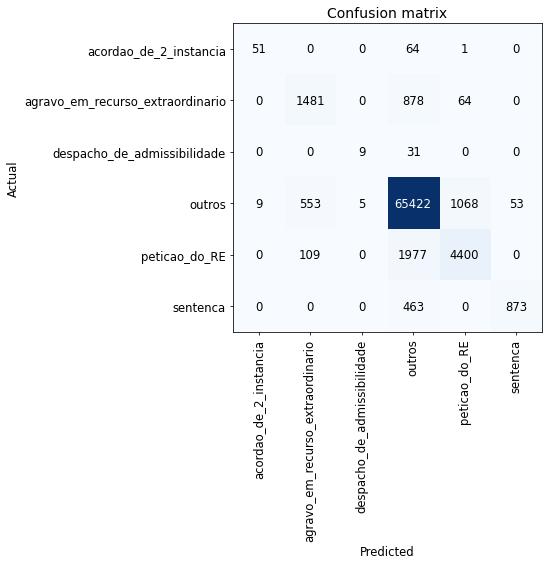

In [84]:
interp = ClassificationInterpretation.from_learner(learn_lm)
interp.plot_confusion_matrix(figsize=(8,8), dpi=70)
learn_lm.validate()

In [85]:
print(classification_report(y, predictions, target_names=target_names,digits=4))
print(accuracy_score(y, predictions))

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     0.8500    0.4397    0.5795       116
agravo_em_recurso_extraordinario     0.6911    0.6112    0.6487      2423
     despacho_de_admissibilidade     0.6429    0.2250    0.3333        40
                          outros     0.9504    0.9748    0.9625     67110
                   peticao_do_RE     0.7952    0.6784    0.7322      6486
                        sentenca     0.9428    0.6534    0.7719      1336

                        accuracy                         0.9319     77511
                       macro avg     0.8121    0.5971    0.6714     77511
                    weighted avg     0.9289    0.9319    0.9292     77511

0.9319451432699875


In [86]:
print("F1:", f1_score(y, predictions, average='micro'))
print("Accuracy:", accuracy_score(y, predictions))

F1: 0.9319451432699875
Accuracy: 0.9319451432699875


In [142]:
#learn_lm_tags.unfreeze_to()
learn_lm_tags.fit_one_cycle(5, slice(2e-2/10/(2.6**4),2e-2/10), cbs=cbs)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,fbeta_score,time
0,0.143068,0.413707,0.099031,0.900969,1.512414,0.880652,02:40
1,0.130085,0.446954,0.098915,0.901085,1.563543,0.883014,02:40
2,0.106834,0.493845,0.099895,0.900105,1.638605,0.876434,02:40
3,0.091393,0.596722,0.098876,0.901124,1.816156,0.878154,02:39
4,0.078190,0.564567,0.096838,0.903162,1.758685,0.881613,02:39


Better model found at epoch 0 with valid_loss value: 0.41370731592178345.


In [143]:
test_dl = dloader_test_tags.test_dl(df_test_tags['text'])
preds_tags = learn_lm_tags.get_preds(dl=test_dl, with_decoded=True)

In [144]:
preds_tags,y_tags,losses_tags = learn_lm_tags.get_preds(with_loss=True)
predictions_tags = np.argmax(preds_tags, axis = 1)

In [145]:
predictions_tags[:15], y_tags[:15], predictions_tags.shape, y_tags.shape

(tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 torch.Size([77511]),
 torch.Size([77511]))

(#5) [0.41370731592178345,0.09903110563755035,0.9009689092636108,1.5124144554138184,0.8806522912203443]

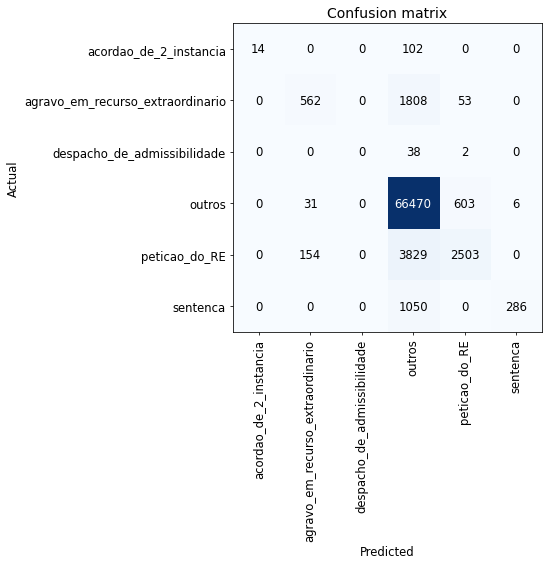

In [146]:
interp_tags = ClassificationInterpretation.from_learner(learn_lm_tags)
interp_tags.plot_confusion_matrix(figsize=(8,8), dpi=70)
learn_lm_tags.validate()

In [147]:
print(classification_report(y_tags, predictions_tags, target_names=target_names, digits=4))
print(accuracy_score(y_tags, predictions_tags))

                                  precision    recall  f1-score   support

          acordao_de_2_instancia     1.0000    0.1207    0.2154       116
agravo_em_recurso_extraordinario     0.7523    0.2319    0.3546      2423
     despacho_de_admissibilidade     0.0000    0.0000    0.0000        40
                          outros     0.9069    0.9905    0.9468     67110
                   peticao_do_RE     0.7918    0.3859    0.5189      6486
                        sentenca     0.9795    0.2141    0.3514      1336

                        accuracy                         0.9010     77511
                       macro avg     0.7384    0.3238    0.3978     77511
                    weighted avg     0.8933    0.9010    0.8807     77511

0.9009688947375212


In [148]:
print("F1:", f1_score(y_tags, predictions_tags, average='micro'))
print("Accuracy:", accuracy_score(y_tags, predictions_tags))

F1: 0.9009688947375212
Accuracy: 0.9009688947375212
